# Introdução aos Modelos de Volatilidade

Seja $P_t$ o preço de um ativo no tempo $t$ ($t$ pode representar meses, semanas, dias, horas, minutos, segundos, etc). Definimos o retorno simples como $$r_t = \dfrac{P_t - P_{t-1}}{P_{t-1}},$$
e definimos o retornos composto (ou log-retorno) como $$r_t = \log(P_t) - \log(P_{t-1}).$$

In [ ]:
#install.packages("yfR")
library(yfR)

In [ ]:
nome_acao <- "PETR4.SA"   # Código no Yahoo Finance
data_ini  <- "2005-01-01" # Data de inicio
data_fim  <- "2019-12-31" # Data de fim
precos <- yf_get(tickers = nome_acao, first_date = data_ini, last_date = data_fim)
head(precos)



── Running yfR for 1 stocks | 2005-01-01 --> 2019-12-31 (5477 days) ──



ℹ Downloading data for benchmark ticker ^GSPC

ℹ (1/1) Fetching data for PETR4.SA

✔ 	- found cache file (2010-01-04 --> 2019-12-30)

! 	- need new data (cache doesnt match query)

✔ 	- got 3729 valid rows (2005-01-03 --> 2019-12-30)

✔ 	- got 96% of valid prices -- Well done !

ℹ Binding price data



── Diagnostics ─────────────────────────────────────────────────────────────────

✔ Returned dataframe with 3729 rows -- Well done !

ℹ Using 1.5 MB at /tmp/RtmpPJgqP5/yf_cache for 3 cache files

ℹ Out of 1 requested tickers, you got 1 (100%)



ticker,ref_date,price_open,price_high,price_low,price_close,volume,price_adjusted,ret_adjusted_prices,ret_closing_prices,cumret_adjusted_prices
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PETR4.SA,2005-01-03,12.18750,12.23750,11.77375,11.77500,30044800,3.340943,NA,NA,1.0000000
PETR4.SA,2005-01-04,11.87375,11.95000,11.62500,11.63500,37667200,3.301220,-0.011889591,-0.011889545,0.9881104
PETR4.SA,2005-01-05,11.66250,11.77250,11.47500,11.59000,30873600,3.288453,-0.003867453,-0.003867647,0.9842889
PETR4.SA,2005-01-06,11.65250,11.68750,11.48750,11.62500,28224000,3.298383,0.003019843,0.003019831,0.9872613
PETR4.SA,2005-01-07,11.64875,11.78750,11.56375,11.67625,25980800,3.312926,0.004408858,0.004408642,0.9916140
PETR4.SA,2005-01-10,11.75000,11.80625,11.47000,11.52500,34800000,3.270010,-0.012954127,-0.012953717,0.9787685


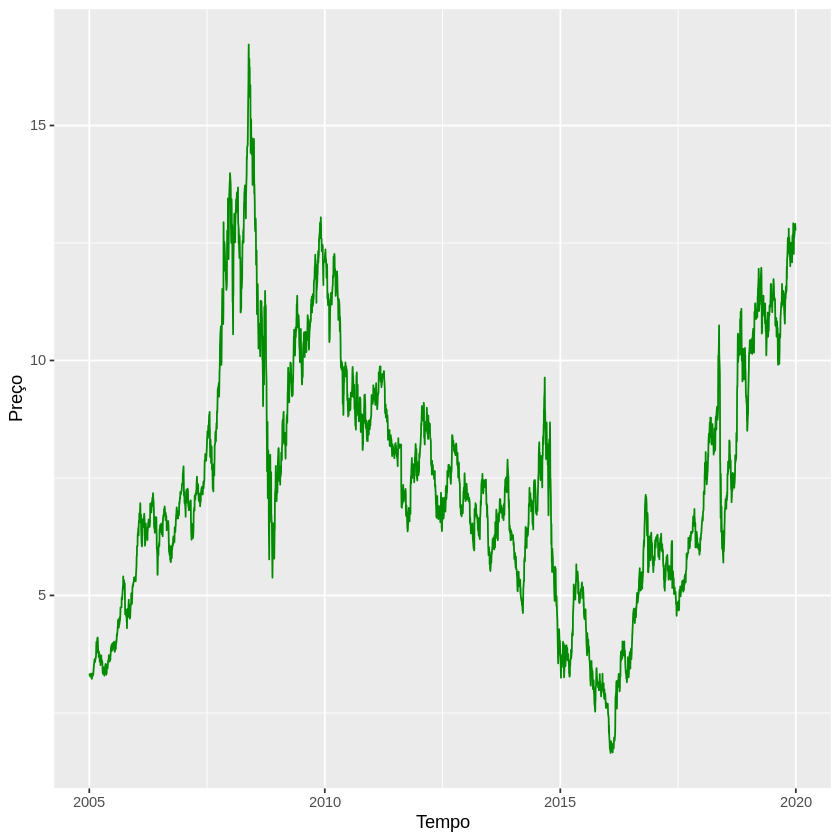

In [ ]:
library(ggplot2)
ggplot(precos) + 
  geom_line(aes(x =ref_date, y = price_adjusted), color = "green4") +
  xlab("Tempo") + ylab("Preço")

Warning message:
“Removed 1 row containing missing values (`geom_line()`).”


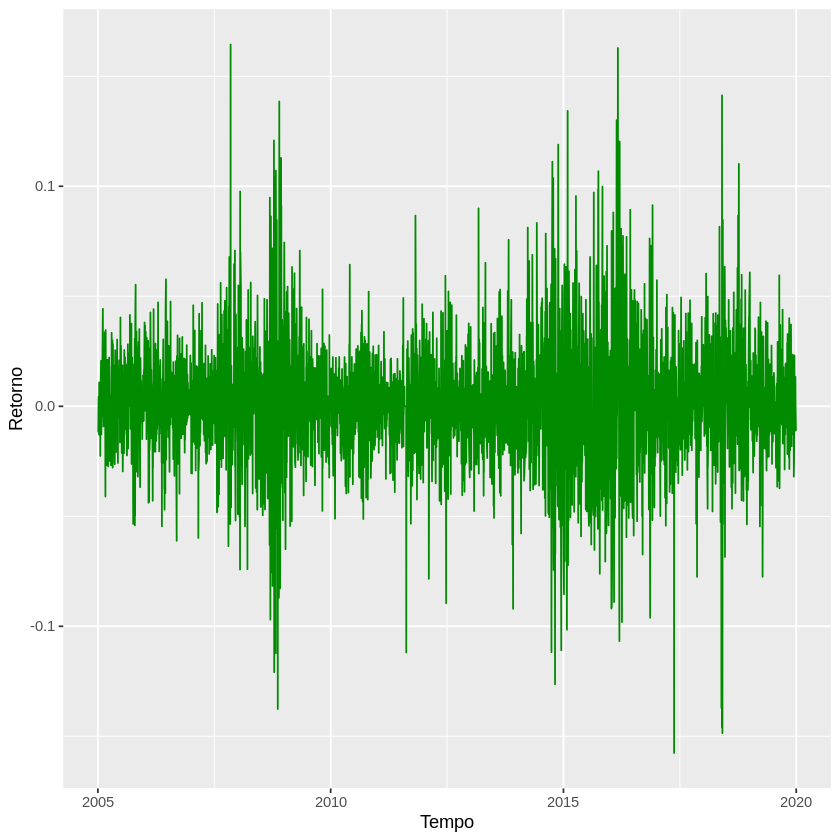

In [ ]:
ggplot(precos) + 
  geom_line(aes(x =ref_date, y = ret_adjusted_prices), color = "green4") +
  xlab("Tempo") + ylab("Retorno")

Nos modelos ARMA(p,q) assumimos que $\epsilon_t \sim RB(0, \sigma^2)$, mas essa variância constante pode não sempre acontecer.

Sejam $\mu_t$ e $\sigma_t^2$ a média e a variância conditional de $r_t$ (condicional nas observações passadas), ou seja: 

$$\mu_t = \mathbb{E}(r_t | \mathcal{F}_{t-1}) \quad e \quad \sigma_t^2 = \mathbb{V}(r_t | \mathcal{F}_{t-1}),$$ em que $\mathcal{F}_{t-1} = \{r_{t-1}, r_{t-2}, \cdots, r_1\}.$

Vamos supor que $\mu_t = 0 \quad \forall t$, ou seja $$\sigma_t^2 = \mathbb{E}(r_t^2 | \mathcal{F}_{t-1})$$

> O objetivo dos modelos de volatilidade (variância condicional ou desvio padrão condicional) é modelar $\sigma_t^2$ ou $\sigma_t$.

**Observação:** na prática, caso $\mu_t = \mu \neq 0$, podemos centrar a série $\tilde{r}_t = r_t - \mu$. Se $\mu_t$ muda ao longo do tempo, podemos aplicar um ARMA como passo prévio.

## Modelos ARCH

- Os modelos ARCH (Autoregressive conditional Heteroskedasticity) forma propostos por Engle (1982) para estimar a variância da inflação no Reino Unido.
- A ideia principal é que os retornos são serialmente não correlacionados (autocorrelação zero) mas a volatilidade depende dos retornos passados através de uma função quadrática (os quadrados dos retornos são serialmente correlacionados).


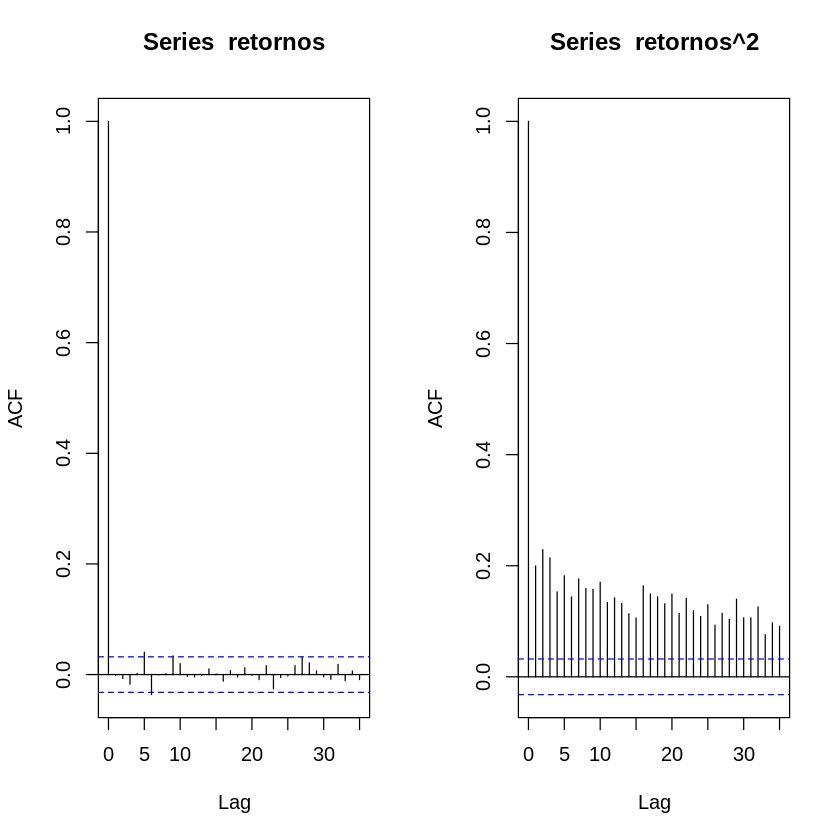

In [ ]:
retornos = precos$ret_adjusted_prices[-1]
op = par(mfrow = c(1,2))
acf(retornos)
acf(retornos^2)
par(op)

O modelo proposto por Engle (1982) é definido como:

**Definição:** Um modelo ARCH(m) é definido como 


\begin{align} 
r_t & = \sigma_t \epsilon_t \\
\sigma_t^2 & = \omega + \displaystyle \sum_{i = 1}^m \alpha_i r_{t-i}^2,
\end{align} em que $\epsilon_t$ é \textit{iid} com média zero, variância um, $\omega > 0$ e $\alpha_i \geq 0$.

> Na prática utiliamos $\epsilon_t \sim N(0,1)$ ou $\epsilon_t \sim t_{\nu}$ (Student-t padronizada para ter variância 1).




**Propriedades:**

- $\mathbb{E}(r_t) = 0.$
- $\mathbb{V}(r_t) = \dfrac{\omega}{1 - \alpha_1 - \cdots - \alpha_m}$
- $\mathbb{C}ov(r_t, r_{t+k}) = 0$

**Identificação:**

ACF dos retornos e retornos ao quadrado já nos dão uma boa indicação se precisamos ou não modelar as variâncias condicionais. Mas, formalmente:

1. Ajustar um ARMA se for o caso (fazemos isto para remover a correlação serial da série). Caso não seja necessário, basta centrarmos a série.

$$\phi(B)r_t = \theta_0 + \theta(B)\epsilon_t \quad ou \quad r_t - \mu = \epsilon_t$$

> Vamos assumir que nenhum filtro foi feito e continuaremos utilizando a notação $r_t$. Caso tenhamos aplicado um ARMA ou centrado a série, $r_t$ refere-se aos resíduos destes filtros.

2. Verificar se a série apresenta heterocedasticidade condicional. Isto pode ser feito utilizando o teste de Ljung-Box | Box-Pierce em $r_t^2$ ou utilizando o teste LM-ARCH.






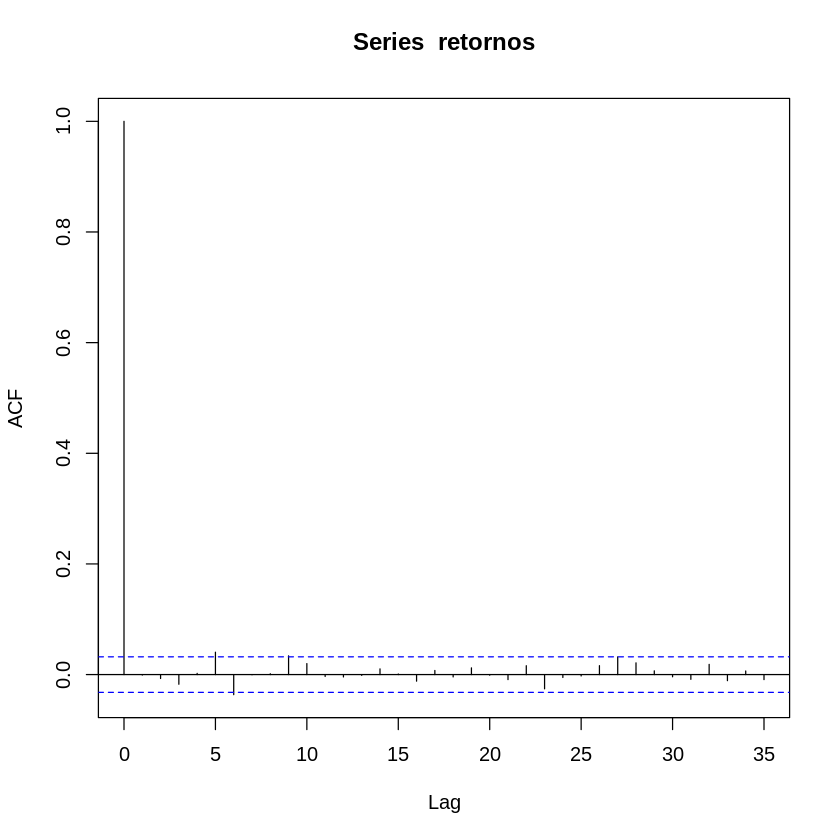

In [ ]:
acf(retornos)

In [ ]:
Box.test(retornos, type = "Ljung-Box", lag = 10)


	Box-Ljung test

data:  retornos
X-squared = 18.136, df = 10, p-value = 0.05271


In [ ]:
summary(retornos)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.1575915 -0.0135470  0.0003775  0.0007284  0.0139640  0.1644131 

In [ ]:
retornos_c = scale(retornos, center = TRUE, scale = FALSE)

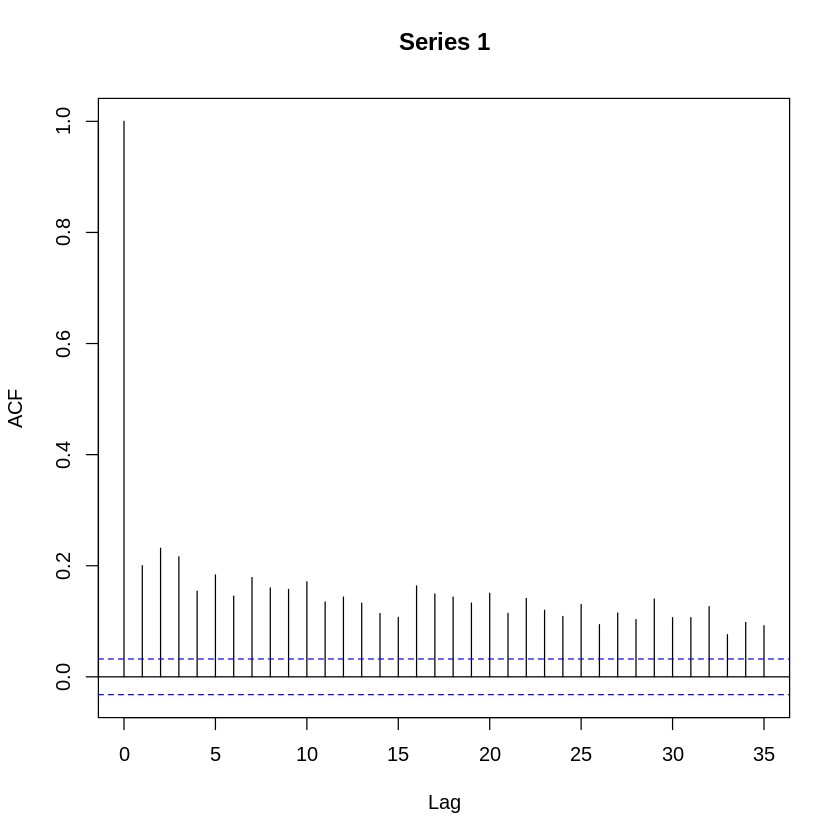

In [ ]:
acf(retornos_c^2)

In [ ]:
Box.test(retornos_c^2, type = "Ljung-Box", lag = 10)


	Box-Ljung test

data:  retornos_c^2
X-squared = 1234.4, df = 10, p-value < 2.2e-16


**Estimação:**

Já identificado que precisamos modelar a variância condicional, precisamos de algum método de estimação. Utilizaremos o método da máxima verossimilhança condicional.

A função de verossimilhança é dada por

$$f(r_T, r_{T-1}, \cdots, r_1 | \Theta) = f(r_T | \mathcal{F}_{t-1}, \Theta) f(r_{T-1} | \mathcal{F}_{T-2}, \Theta), \cdots f(r_{m+1}| \mathcal{F}_{m}, \Theta) f(r_1, r_2, \cdots, r_m | \Theta),$$ em que $\Theta = (\omega, \alpha_1, \cdots, \alpha_m).$

Como $r_m = \sigma_m \epsilon_m$ e $\sigma_m^2 = \omega + \alpha_1 r_{m-1}^2 + \cdots \alpha_m r_{0}^2$, podemos, como no caso ARMA, começar a verossimilhança em $m+1$ e condicionar nos valores passados.


Assumindo normalidade:

$$L(\Theta) = \displaystyle \prod_{i = m+1}^T  (2 \pi \sigma_i^2)^{-1/2} e^{\dfrac{-r_i^2}{2\sigma_i^2}},$$


$$l(\Theta) = \displaystyle \sum_{i = m+1}^T \dfrac{-r_i^2}{2\sigma_i^2} - \dfrac{1}{2} \log(2 \pi \sigma_i^2),$$

$$l(\Theta) \propto \displaystyle \sum_{i = m+1}^T \dfrac{-r_i^2}{2\sigma_i^2} - \log(\sigma_i).$$


Assim, para obtermos os estimadore de máxima verossimilhança, basta maximizar $l(\Theta)$ ou minimizar $-l(\Theta)$-


> Como implementamos o método no computador?

In [46]:
#install.packages("rugarch")
library(rugarch)

In [47]:
spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE),
                   variance.model = list(model = 'sGARCH', garchOrder = c(3, 0)),
                   distribution = 'norm')

In [48]:
fit_01 <- ugarchfit(spec, retornos_c, solver = 'hybrid')

**Verificação:**


1. Calculamos os resíduos (padranizados), _i.e,_ $\hat{\epsilon}_t = r_t / \hat{\sigma}_t$
2. Verificamos se existe correlação serial nos $\hat{\epsilon}_t$ (Ljung-Box)
3. Verificamos se existe correlação serial nos $\hat{\epsilon}_t^2$ (Ljung-Box, LM-ARCH)
4. Verificamos se $\hat{\epsilon}_t$ se comportam como a distribuição que assumimos ser a correta (Normal ou t-Student).

> Se encontrarmos um modelo que capturou a dinâmica dos dados, passamos para a etapa de previsão.

In [49]:
fit_01


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(3,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000365    0.000016  23.5064        0
alpha1  0.147237    0.022559   6.5267        0
alpha2  0.184054    0.023729   7.7566        0
alpha3  0.183737    0.026138   7.0295        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000365    0.000031  11.6149  0.0e+00
alpha1  0.147237    0.036349   4.0507  5.1e-05
alpha2  0.184054    0.033369   5.5156  0.0e+00
alpha3  0.183737    0.041789   4.3968  1.1e-05

LogLikelihood : 8445.759 

Information Criteria
------------------------------------
                    
Akaike       -4.5288
Bayes        -4.5222
Shibata      -4.5288
Hannan-Quinn -4.5265

Weig

In [58]:
spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE),
                   variance.model = list(model = 'sGARCH', garchOrder = c(4, 0)),
                   distribution = 'norm')
fit_02 <- ugarchfit(spec, retornos_c, solver = 'hybrid')
fit_02


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(4,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000308    0.000015  20.7610        0
alpha1  0.128891    0.021762   5.9227        0
alpha2  0.142541    0.021569   6.6086        0
alpha3  0.162546    0.024845   6.5424        0
alpha4  0.162444    0.022977   7.0700        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000308    0.000026  11.6612 0.000000
alpha1  0.128891    0.035343   3.6469 0.000265
alpha2  0.142541    0.027589   5.1667 0.000000
alpha3  0.162546    0.039417   4.1238 0.000037
alpha4  0.162444    0.038679   4.1998 0.000027

LogLikelihood : 8496.102 

Information Criteria
------------------------------------
                

In [59]:
spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE),
                   variance.model = list(model = 'sGARCH', garchOrder = c(5, 0)),
                   distribution = 'norm')
fit_03 <- ugarchfit(spec, retornos_c, solver = 'hybrid')
fit_03


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(5,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000275    0.000014  19.1296    0e+00
alpha1  0.111325    0.020986   5.3046    0e+00
alpha2  0.133577    0.020800   6.4219    0e+00
alpha3  0.119755    0.024049   4.9797    1e-06
alpha4  0.152534    0.021963   6.9451    0e+00
alpha5  0.118684    0.020069   5.9138    0e+00

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000275    0.000025  11.1982 0.000000
alpha1  0.111325    0.034133   3.2615 0.001108
alpha2  0.133577    0.027400   4.8750 0.000001
alpha3  0.119755    0.038865   3.0813 0.002061
alpha4  0.152534    0.038347   3.9777 0.000070
alpha5  0.118684    0.027188   4.3653 0.000013

LogLike

In [60]:
spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE),
                   variance.model = list(model = 'sGARCH', garchOrder = c(6, 0)),
                   distribution = 'norm')
fit_04 <- ugarchfit(spec, retornos_c, solver = 'hybrid')
fit_04


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(6,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000246    0.000014  17.2904        0
alpha1  0.107018    0.020400   5.2459        0
alpha2  0.108413    0.019533   5.5502        0
alpha3  0.119457    0.023372   5.1111        0
alpha4  0.115997    0.020943   5.5387        0
alpha5  0.105668    0.019256   5.4875        0
alpha6  0.119829    0.023285   5.1463        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000246    0.000026   9.2826 0.000000
alpha1  0.107018    0.034441   3.1073 0.001888
alpha2  0.108413    0.023376   4.6377 0.000004
alpha3  0.119457    0.038675   3.0887 0.002010
alpha4  0.115997    0.029154   3.9788 0.000069
alpha5  

In [61]:
spec <- ugarchspec(mean.model = list(armaOrder = c(0, 0), include.mean = FALSE),
                   variance.model = list(model = 'sGARCH', garchOrder = c(7, 0)),
                   distribution = 'norm')
fit_05 <- ugarchfit(spec, retornos_c, solver = 'hybrid')
fit_05


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: sGARCH(7,0)
Mean Model	: ARFIMA(0,0,0)
Distribution	: norm 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000008    0.000001   13.045        0
alpha1  0.087070    0.001265   68.828        0
alpha2  0.095926    0.001402   68.420        0
alpha3  0.088235    0.001281   68.901        0
alpha4  0.090229    0.001312   68.764        0
alpha5  0.090703    0.001320   68.714        0
alpha6  0.108459    0.001585   68.410        0
alpha7  0.092548    0.001350   68.557        0

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
omega   0.000008    0.000001   8.0689        0
alpha1  0.087070    0.000507 171.8282        0
alpha2  0.095926    0.000611 156.9941        0
alpha3  0.088235    0.000452 195.3246        0
alpha4  

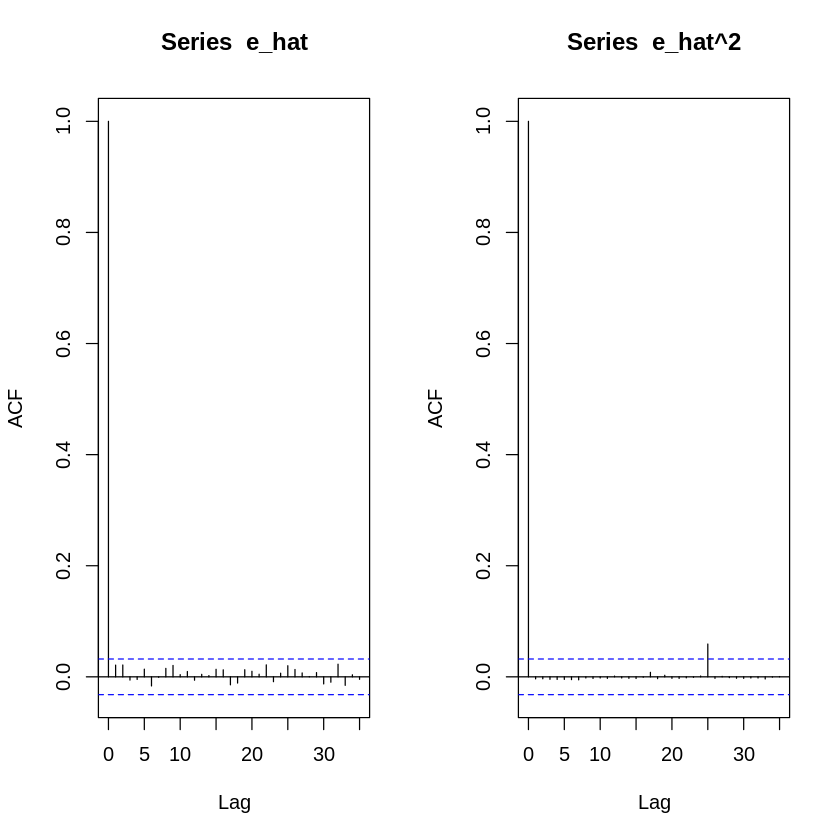

In [82]:
e_hat = fit_05@fit$residuals/fit_05@fit$sigma
op = par(mfrow = c(1,2))
acf(e_hat)
acf(e_hat^2)
par(op)

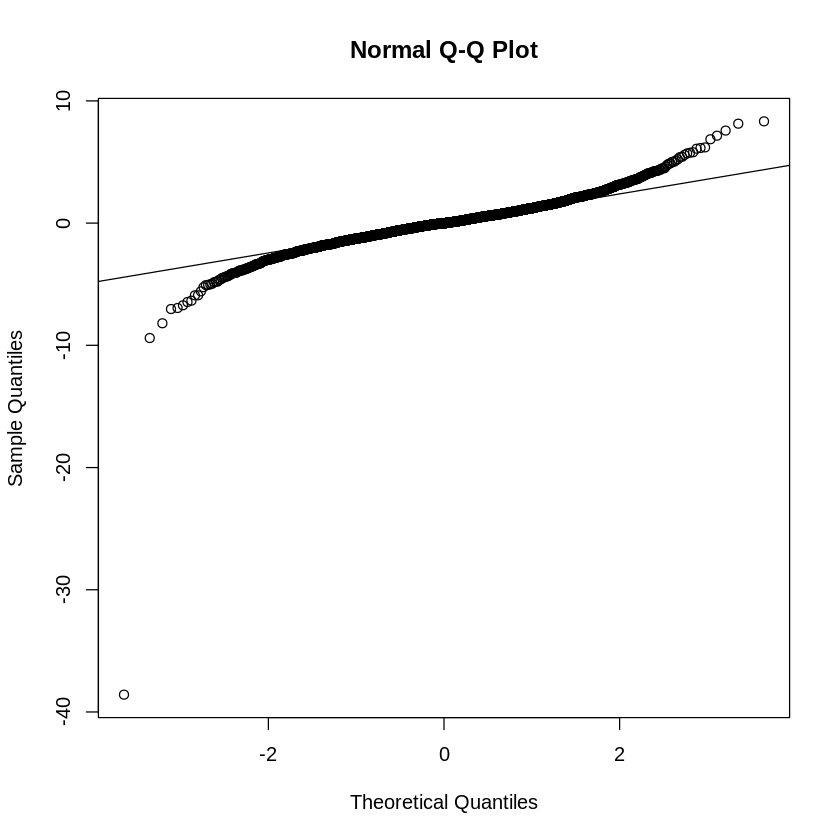

In [83]:
qqnorm(e_hat)
qqline(e_hat)

> Com fins ilustrativos vamos ignorar esse fato e continuar com a previsão. Mas, saiba que quando estiver na vida real, isto não deve ser ignorado.

**Previsão:**

As previsões para a variância condicional em um modelo ARCH(m) são obtidas recursivamente:

- $\hat{\sigma}_{T+1|T}^2 = \hat{\omega} + \hat{\alpha}_1 r_{T}^2 + \hat{\alpha}_2 r_{T-1}^2 + \cdots + \hat{\alpha}_m r_{T-m}^2$

- $\hat{\sigma}_{T+k|T}^2 = \hat{\omega} + \displaystyle \sum_{i=1}^m \hat{\alpha_i} \hat{\sigma}_{T+k-i|T}$ em que $\hat{\sigma}_{T+k-i|T} = r_{T + k -i}^2$ se $k-i \leq 0$.

In [ ]:
fore_06 = ugarchforecast(fit_05, n.ahead = 5)
fore_06

O pacote `rugarch` tem muita coisa, caso esteja interessado, de uma olhada [neste tutorial.](http://www.unstarched.net/r-examples/rugarch/a-short-introduction-to-the-rugarch-package/)

**Para praticar:**

- Utilize a série "VALE3" e construa um modelo apropriado que capture a dinâmica dos dados.